In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#helps unboxing the blackbox
import shap

import imblearn as imb
from imblearn.over_sampling import SMOTE

In [ ]:
# --- Model selection utilities ---
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# --- Preprocessing tools ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# --- Classification models ---
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
# --- Evaluation metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    auc,
)

from sklearn.inspection import permutation_importance


In [23]:
df = pd.read_csv('../../data/diabetes_nnorm.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']


--- Working on fold 1 ---


C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
100%|██████████| 154/154 [01:09<00:00,  2.23it/s]
C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 1 — F1 score: 0.6885
  Accuracy: 0.7532
  Precision: 0.6176
  Recall: 0.7778
  ROC AUC: 0.8121
  Best n_neighbors: 9
  Best weights: distance
  Best metric: manhattan

--- Working on fold 2 ---


100%|██████████| 154/154 [01:26<00:00,  1.77it/s]
C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 2 — F1 score: 0.6372
  Accuracy: 0.7338
  Precision: 0.6102
  Recall: 0.6667
  ROC AUC: 0.8058
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 3 ---


100%|██████████| 154/154 [01:31<00:00,  1.68it/s]
C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 3 — F1 score: 0.6341
  Accuracy: 0.7078
  Precision: 0.5652
  Recall: 0.7222
  ROC AUC: 0.7716
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 4 ---


100%|██████████| 153/153 [01:04<00:00,  2.37it/s]
C:\Users\micha\OneDrive - Universität Zürich UZH\6.Semester\04-project\FoDS-Diabetes-Diagnosis\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 4 — F1 score: 0.6261
  Accuracy: 0.7190
  Precision: 0.5806
  Recall: 0.6792
  ROC AUC: 0.7843
  Best n_neighbors: 5
  Best weights: distance
  Best metric: euclidean

--- Working on fold 5 ---


100%|██████████| 153/153 [00:37<00:00,  4.10it/s]

Fold 5 — F1 score: 0.6290
  Accuracy: 0.6993
  Precision: 0.5493
  Recall: 0.7358
  ROC AUC: 0.7411
  Best n_neighbors: 5
  Best weights: distance
  Best metric: manhattan


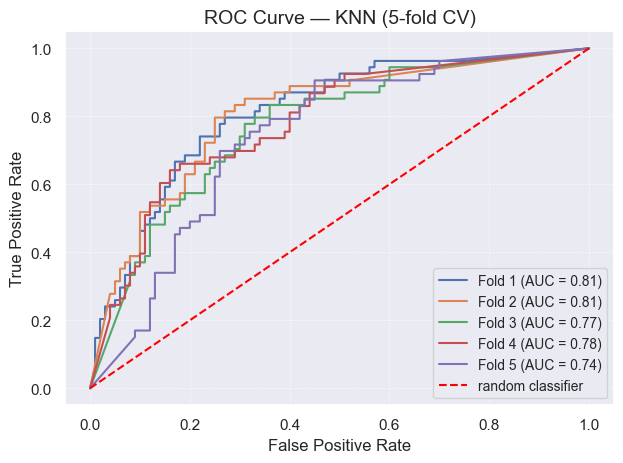

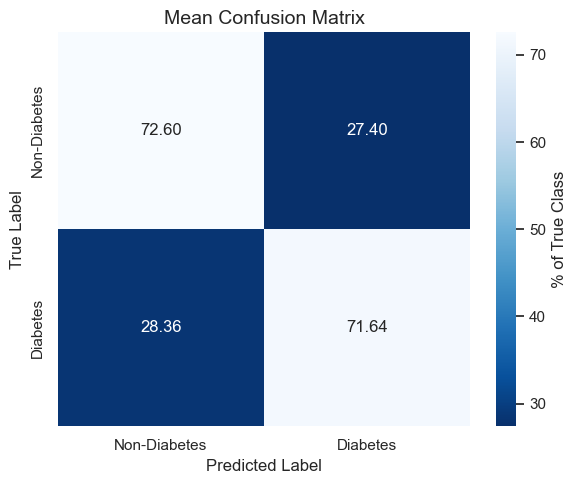

In [24]:
# --- Hyperparameter grid ---
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# --- Initialize storage ---
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
models = []
f1_scores = []
roc_curves = []
conf_matrices = []
fold = 1

# SHAP-related
shap_values_all = []
shap_test_sets = []

# Define cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation loop ---
for train_index, test_index in cv.split(X, y):
    print(f'\n--- Working on fold {fold} ---')

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to training data
    smote = SMOTE(random_state=fold)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Grid search on scaled, resampled training data
    knn = KNeighborsClassifier()
    clf_GS = GridSearchCV(knn, parameters, cv=5, scoring='f1')
    clf_GS.fit(X_train_scaled, y_train_resampled)

    # Evaluate best model
    best_model = clf_GS.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # SHAP: use sampled background for speed
    background = shap.sample(X_train_scaled, 100, random_state=fold)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_all.append(shap_values)
    shap_test_sets.append(pd.DataFrame(X_test_scaled, columns=X.columns))

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    metrics['roc_auc'].append(roc_auc)
    roc_curves.append((fpr, tpr, roc_auc, fold))
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    # Classification metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Fold {fold} — F1 score: {f1:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print('  Best n_neighbors:', best_model.get_params()['n_neighbors'])
    print('  Best weights:', best_model.get_params()['weights'])
    print('  Best metric:', best_model.get_params()['metric'])

    # Store results
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    f1_scores.append(f1)
    models.append(best_model)

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    fold += 1

# --- Identify best model ---
best_index = f1_scores.index(max(f1_scores))
best_model_overall = models[best_index]

# Reconstruct best model for export/deployment
params = best_model_overall.get_params()
b_model = KNeighborsClassifier(
    n_neighbors=params["n_neighbors"],
    weights=params["weights"],
    metric=params["metric"]
)

# --- Final ROC plot ---
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — KNN (5-fold CV)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Confusion Matrix Plot ---
plt.close('all')
plt.figure(figsize=(6, 5))
mean_cm = np.mean(conf_matrices, axis=0)
mean_cm_percent = 100 * mean_cm / mean_cm.sum(axis=1, keepdims=True)

class_labels = ['Non-Diabetes', 'Diabetes']
sns.heatmap(mean_cm_percent, annot=True, fmt='.2f', cmap='Blues_r',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': '% of True Class'})
plt.title('Mean Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [49]:
# Combine SHAP values for class 1
all_shap_values = np.vstack([sv[:, :, 1] for sv in shap_values_all])

# Concatenate test sets
all_X_test = pd.concat(shap_test_sets, axis=0)
all_X_test.columns = X.columns
feature_names = X.columns

# Generate SHAP summary plot (SHAP creates its own figure)
shap.summary_plot(all_shap_values, all_X_test, feature_names=feature_names, show=False)

# Get the figure SHAP actually created
fig = plt.gcf()
ax = plt.gca()

# Set background colors to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Add title and labels
plt.title('KNN – SHAP Feature Importance\n(Aggregated Across Outer Folds)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Predicting Diabetes)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Remove grid
ax.grid(False)

# Save and close
plt.tight_layout()
plt.savefig('../../output/KNN_output/knn_shap_final.png', dpi=300, facecolor='white')
plt.close()
